In [42]:
import torch
from torch import nn, optim

import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from tqdm import tqdm

%matplotlib inline

In [2]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [3]:
mu1 = torch.tensor([10., 3.], device=device, dtype=torch.float32)
mu2 = torch.tensor([3., 0.], device=device, dtype=torch.float32)
covar = torch.tensor([[1., 0.], [0., 1.]], device=device, dtype=torch.float32)

p_data = 0.7 # prob of the first peak in data space
N = 10000 # amount of data

batch_size = 100
num_epoches = 250
z_dim = 2

In [5]:
c = torch.distributions.Bernoulli(p_data). sample((N, )).to(device).view(-1, 1)
a = torch.distributions.MultivariateNormal(loc=mu1, covariance_matrix=covar).sample((N, ))
b = torch.distributions.MultivariateNormal(loc=mu2, covariance_matrix=covar).sample((N, ))

In [6]:
X = c * a + (1 - c) * b
Y = torch.cat((X, c), 1)

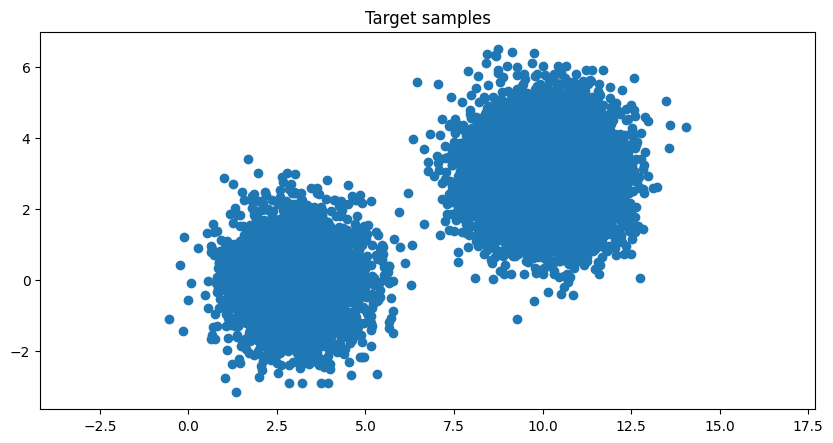

In [7]:
plt.figure(figsize=(10, 5), dpi=100)
plt.title('Target samples')
plt.axis('equal')
plt.scatter(Y[:, 0].cpu(), Y[:, 1].cpu());

In [8]:
class VAE_stand_prior(nn.Module):
  def __init__(self):
    super(VAE_stand_prior, self).__init__()

    self.fc0 = nn.Linear(2, 5) # for encoder
    self.fc1 = nn.Linear(5, 10)
    self.fc2 = nn.Linear(10, z_dim) 
    self.fc3 = nn.Linear(10, z_dim)

    self.fc4 = nn.Linear(z_dim, 10) # for decoder
    self.fc5 = nn.Linear(10, 5)
    self.fc6 = nn.Linear(5, 2)

  def encode(self, x):
    h = torch.relu(self.fc0(x))
    g = torch.relu(self.fc1(h))
    return self.fc2(g), self.fc3(g) # mu and logvar -- parameters of q_{phi}
    
  def reparametrize(self, mu, logvar):
    std = torch.exp(logvar * 0.5)
    eps = torch.randn_like(std)
    return mu + eps * std
  
  def decode(self, z):
    h = torch.relu(self.fc4(z))
    g = torch.relu(self.fc5(h))
    return self.fc6(g) # mu_0 -- parameter of p_{theta}

  def forward(self, x):
    mu, logvar = self.encode(x)
    z = self.reparametrize(mu, logvar)
    return self.decode(z), mu, logvar

In [9]:
model = VAE_stand_prior().to(device)
optimizer = optim.Adam(params=model.parameters(), lr=1e-3)

In [10]:
def loss_function(x, mu_0, mu, logvar):
    KL = -0.5 * (1 + logvar - mu.pow(2) - logvar.exp()) # KL-divergence
    distr = torch.distributions.MultivariateNormal(loc=mu_0, covariance_matrix=covar)
    ELH = distr.log_prob(x) # 1-MC approximation of expected log likelihood
    return KL.mean() - ELH.mean()

In [11]:
dataloader = DataLoader(X, batch_size=batch_size, shuffle=True, )

In [12]:
for epoch in tqdm(range(num_epoches)):
    for batch in dataloader:
        mu_0, mu, logvar = model(batch)
        loss = loss_function(batch, mu_0, mu, logvar)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    if epoch % 50 == 0:
        print("loss =", loss.cpu().detach().numpy())

  0%|          | 1/250 [00:00<01:36,  2.59it/s]

loss = 41.20925


 20%|██        | 51/250 [00:13<00:49,  4.01it/s]

loss = 3.2237341


 40%|████      | 101/250 [00:25<00:37,  3.99it/s]

loss = 3.1641703


 60%|██████    | 151/250 [00:38<00:24,  4.06it/s]

loss = 3.0993094


 80%|████████  | 201/250 [00:50<00:12,  3.97it/s]

loss = 3.0726395


100%|██████████| 250/250 [01:03<00:00,  3.97it/s]


##Generation

In [13]:
prior = torch.distributions.normal.Normal(torch.tensor(0., device=device, dtype=torch.float32),
                                          torch.tensor(1., device=device, dtype=torch.float32),)

In [14]:
pr_samples = prior.sample((1000, z_dim))

In [15]:
mu_0 = model.decode(pr_samples).detach().cpu()

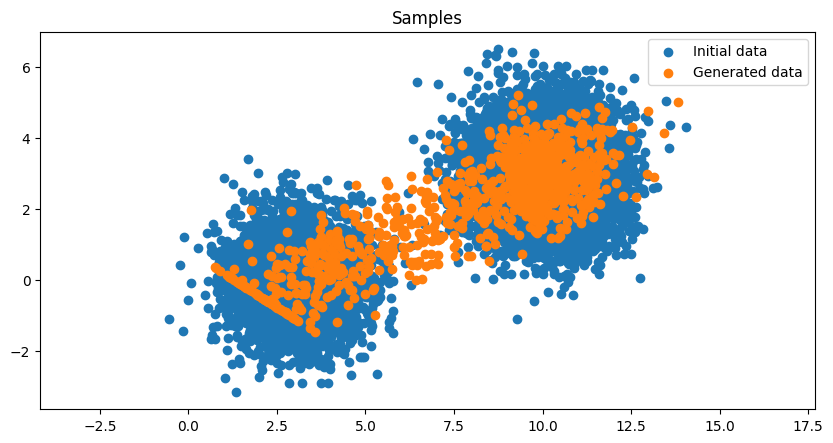

In [16]:
plt.figure(figsize=(10, 5), dpi=100)
plt.title('Samples')
plt.scatter(X.cpu()[:, 0], X.cpu()[:, 1], label='Initial data')
plt.scatter(mu_0[:, 0], mu_0[:, 1], label='Generated data')
plt.axis('equal')
plt.legend();

##Prior visualization

No handles with labels found to put in legend.


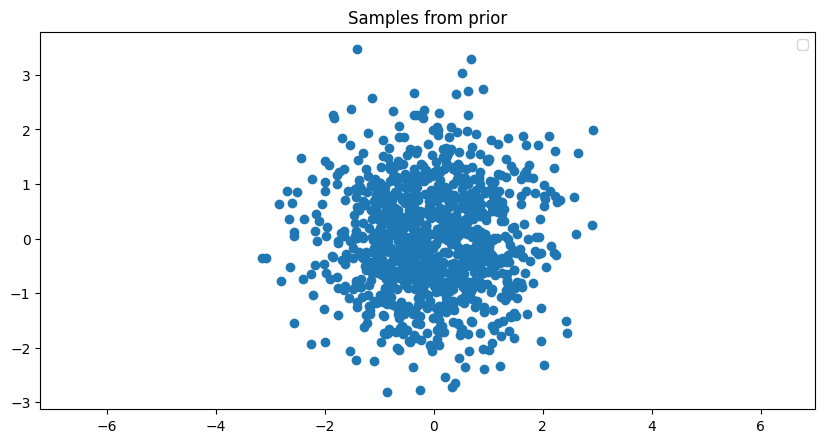

In [17]:
plt.figure(figsize=(10, 5), dpi=100)
plt.title('Samples from prior')
plt.scatter(pr_samples[:, 0].cpu(), pr_samples[:, 1].cpu())
plt.axis('equal')
plt.legend();

##Reconstruction

In [18]:
X_rec = model(X) #reconstructed data

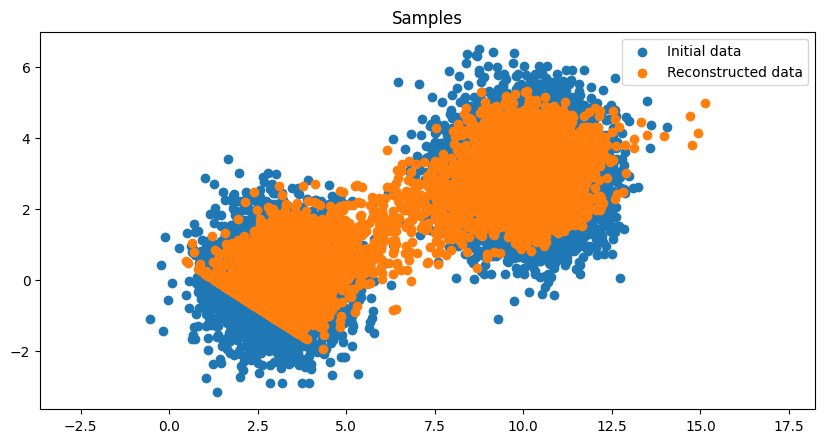

In [19]:
plt.figure(figsize=(10, 5), dpi=100)
plt.title('Samples')
plt.scatter(X[:, 0].cpu(), X[:, 1].cpu(), label='Initial data')
plt.scatter(X_rec[0][:, 0].detach().cpu(), X_rec[0][:, 1].detach().cpu(), label='Reconstructed data')
plt.axis('equal')
plt.legend();

## Latent space illustration

In [20]:
mu_1, logvar_1 = model.encode(Y[Y[:, 2] == 0, 0:2])
mu_2, logvar_2 = model.encode(Y[Y[:, 2] == 1, 0:2])

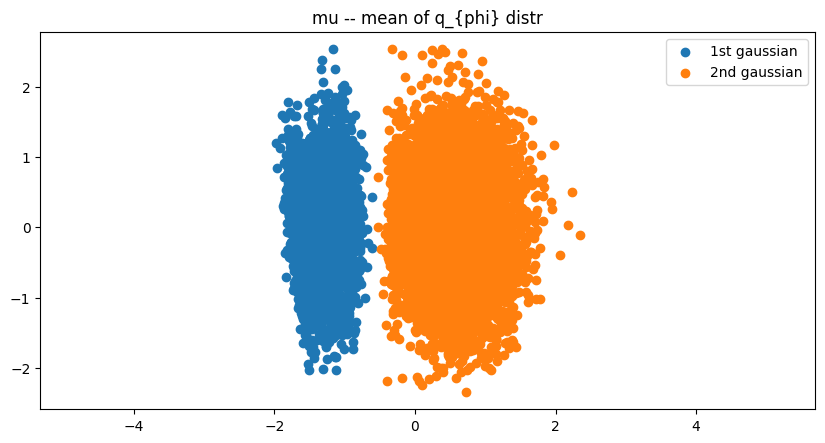

In [21]:
plt.figure(figsize=(10, 5), dpi=100)
plt.title('mu -- mean of q_{phi} distr')
plt.scatter(mu_1[:, 0].detach().cpu(), mu_1[:, 1].detach().cpu(), label='1st gaussian')
plt.scatter(mu_2[:, 0].detach().cpu(), mu_2[:, 1].detach().cpu(), label='2nd gaussian')
plt.axis('equal')
plt.legend();

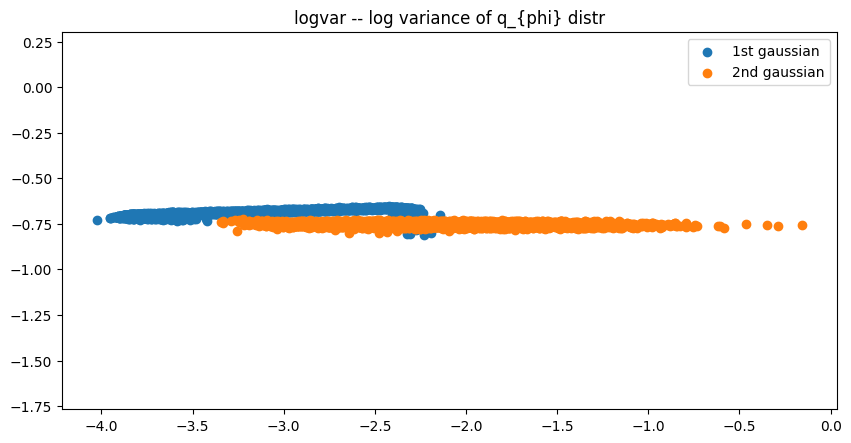

In [22]:
plt.figure(figsize=(10, 5), dpi=100)
plt.title('logvar -- log variance of q_{phi} distr')
plt.scatter(logvar_1[:, 0].detach().cpu(), logvar_1[:, 1].detach().cpu(), label='1st gaussian')
plt.scatter(logvar_2[:, 0].detach().cpu(), logvar_2[:, 1].detach().cpu(), label='2nd gaussian')
plt.axis('equal')
plt.legend();

## $\log{p_{\theta}(X)}$ estimation

$\log{p_{\theta}(X)} = \sum{\log{p_{\theta}(x_i)}}$

Fixed $x\in X$:

$\log{p_{\theta}(x)} = \log{\int_{z}{p_{\theta}(x,z)dz}} = \log{\int_{z}{q_{\varphi}(z|x)\frac{p_{\theta}(x,z)}{q_{\varphi}(z|x)}dz}}\approx \log{\frac{1}{N_{s}}\sum_{i=1}^{N_{IS}}{\frac{p_{\theta}(x,z_{i})}{q_{\varphi}(z_{i}|x)}}} = -\log{N_{IS}} + \log sum_i \exp(\log{p_{\theta}(x, z_i)} - \log{q_{\varphi}(z_i|x)}$

In [23]:
N_IS = 1000
N_test = 2000

In [24]:
c_test = torch.distributions.Bernoulli(p_data). sample((N_test, )).to(device).view(-1, 1)
a_test = torch.distributions.MultivariateNormal(loc=mu1, covariance_matrix=covar).sample((N_test, ))
b_test = torch.distributions.MultivariateNormal(loc=mu2, covariance_matrix=covar).sample((N_test, ))

In [25]:
X_test = c_test * a_test + (1 - c_test) * b_test

In [64]:
"""
res = 0
i = 0
for x in X_test:
    mu_q, logvar_q = model.encode(x)
    q_phi = torch.distributions.Normal(loc=mu_q.detach(), scale=(0.5 * logvar_q.detach()).exp())
    Z = q_phi.sample((N_IS, ))
    m_0 = model.decode(Z) # means of p_theta
    p_theta = [torch.distributions.MultivariateNormal(loc=m_0[i].detach(), covariance_matrix=covar) for i in range(N_IS)]
    d = torch.tensor([p_theta[i].log_prob(x) for i in range(N_IS)]) # log p_{theta}(x|z_i)
    e = torch.tensor([prior.log_prob(Z[i]).sum() for i in range(N_IS)]) # log p(z_i)
    f = torch.tensor([q_phi.log_prob(Z[i]).sum() for i in range(N_IS)]) # log q_{phi}(z_i|x)
    res = torch.logsumexp(d + e - f, dim=0) - torch.log(torch.tensor(N_IS, dtype=torch.float32))
    if i % 100 == 0:
        print(i, "cur_res =", res)
    i += 1
"""

'\nres = 0\ni = 0\nfor x in X_test:\n    mu_q, logvar_q = model.encode(x)\n    q_phi = torch.distributions.Normal(loc=mu_q.detach(), scale=(0.5 * logvar_q.detach()).exp())\n    Z = q_phi.sample((N_IS, ))\n    m_0 = model.decode(Z) # means of p_theta\n    p_theta = [torch.distributions.MultivariateNormal(loc=m_0[i].detach(), covariance_matrix=covar) for i in range(N_IS)]\n    d = torch.tensor([p_theta[i].log_prob(x) for i in range(N_IS)]) # log p_{theta}(x|z_i)\n    e = torch.tensor([prior.log_prob(Z[i]).sum() for i in range(N_IS)]) # log p(z_i)\n    f = torch.tensor([q_phi.log_prob(Z[i]).sum() for i in range(N_IS)]) # log q_{phi}(z_i|x)\n    res = torch.logsumexp(d + e - f, dim=0) - torch.log(torch.tensor(N_IS, dtype=torch.float32))\n    if i % 100 == 0:\n        print(i, "cur_res =", res)\n    i += 1\n'

In [65]:
# print("log p(X) =", res)

With minibatches:

In [58]:
test_batch_size = 10
test_dataloader = DataLoader(X_test, batch_size=test_batch_size, shuffle=False, )

In [59]:
batch_mean = []
j = 0
for batch in test_dataloader:
    res = torch.tensor([])
    for x in batch:
        mu_q, logvar_q = model.encode(x)
        q_phi = torch.distributions.Normal(loc=mu_q.detach(), scale=(0.5 * logvar_q.detach()).exp())
        Z = q_phi.sample((N_IS, ))
        m_0 = model.decode(Z) # means of p_theta
        p_theta = [torch.distributions.MultivariateNormal(loc=m_0[i].detach(), covariance_matrix=covar) for i in range(N_IS)]
        a = torch.tensor([p_theta[i].log_prob(x) for i in range(N_IS)]) # log p_{theta}(x|z_i)
        b = torch.tensor([prior.log_prob(Z[i]).sum() for i in range(N_IS)]) # log p(z_i)
        c = torch.tensor([q_phi.log_prob(Z[i]).sum() for i in range(N_IS)]) # log q_{phi}(z_i|x)
        res = torch.cat((res, (torch.logsumexp(a + b - c, dim=0) - torch.log(torch.tensor(N_IS, dtype=torch.float32))).view(-1)), dim=0)
    batch_mean.append(res.mean())
    if j % 10 == 0:
        print("batch #", j, "batch_mean =", res.mean())
    j += 1

batch # 0 batch_mean = tensor(-4.2030)
batch # 10 batch_mean = tensor(-3.7696)
batch # 20 batch_mean = tensor(-3.7594)
batch # 30 batch_mean = tensor(-3.8663)
batch # 40 batch_mean = tensor(-3.3799)
batch # 50 batch_mean = tensor(-3.5759)
batch # 60 batch_mean = tensor(-3.8448)
batch # 70 batch_mean = tensor(-3.7811)
batch # 80 batch_mean = tensor(-4.1247)
batch # 90 batch_mean = tensor(-4.0204)
batch # 100 batch_mean = tensor(-3.4167)
batch # 110 batch_mean = tensor(-3.4907)
batch # 120 batch_mean = tensor(-3.4907)
batch # 130 batch_mean = tensor(-3.6319)
batch # 140 batch_mean = tensor(-3.7347)
batch # 150 batch_mean = tensor(-3.3648)
batch # 160 batch_mean = tensor(-3.2316)
batch # 170 batch_mean = tensor(-3.7205)
batch # 180 batch_mean = tensor(-3.8344)
batch # 190 batch_mean = tensor(-3.5815)


In [60]:
print(batch_mean)

[tensor(-4.2030), tensor(-3.7584), tensor(-3.9206), tensor(-3.3157), tensor(-3.9791), tensor(-3.5016), tensor(-3.3697), tensor(-3.5445), tensor(-3.6425), tensor(-3.8263), tensor(-3.7696), tensor(-3.8484), tensor(-3.3085), tensor(-3.7820), tensor(-3.8666), tensor(-3.9071), tensor(-3.7078), tensor(-4.0327), tensor(-3.4648), tensor(-3.6930), tensor(-3.7594), tensor(-3.4387), tensor(-3.5935), tensor(-3.7777), tensor(-3.6138), tensor(-3.8020), tensor(-3.9503), tensor(-3.7738), tensor(-3.7870), tensor(-3.6400), tensor(-3.8663), tensor(-3.6364), tensor(-3.9387), tensor(-3.9586), tensor(-3.6661), tensor(-3.6505), tensor(-3.7845), tensor(-4.0058), tensor(-3.9048), tensor(-3.4352), tensor(-3.3799), tensor(-4.2529), tensor(-3.7610), tensor(-3.9032), tensor(-3.3343), tensor(-3.5326), tensor(-3.8121), tensor(-3.3197), tensor(-3.8467), tensor(-3.3924), tensor(-3.5759), tensor(-3.7588), tensor(-3.4480), tensor(-3.9007), tensor(-3.5406), tensor(-3.5870), tensor(-4.1358), tensor(-4.0607), tensor(-4.053

In [63]:
print("mean =", torch.tensor(batch_mean).mean().numpy()) # mean of log p_{theta}(x)
print("std =", torch.tensor(batch_mean).std().numpy())

mean = -3.705019
std = 0.2261299
